Демонстрация простой вариационной модели и ее прунинга.

**Disclaimer**: могут быть ошибки, кроме того, функии могут быть написаны неоптимально.

In [2]:
import torch as t 
import torchvision
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms

In [9]:
device = 'cpu' # cuda or cpu

In [4]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 5 #количество эпох
lam = 1.0 # коэффициент перед дивергенцией
hidden_num = 10 # количество нейронов на скрытом слое
t.manual_seed(42) # задаем значение генератора случайных чисел для повторяемости экспериментов


In [5]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)


In [6]:
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_, device=device)) # параметры средних
        t.nn.init.xavier_uniform(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_, device = device)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_, device=device)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_, device=device) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b,  t.exp(self.log_sigma_b))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2

In [7]:
class VarSeqNet(nn.Sequential):    
    # класс-обертка на случай, если у нас многослойная нейронная сеть
    def KLD(self):
        k = 0
        for l in self:
            k+=l.KLD()
        return k

In [26]:
# рассмотрим для примера сеть, состояющую из двух слоев
# второй слой - softmax. По сути для обучения задавать активацию явно не нужно, она забита в nn.CrossEntropyLoss
nets=[]
for i in range(2):
    nets.append(VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)))
    optimizer = optim.Adam(nets[i].parameters())
    loss_fn = nn.CrossEntropyLoss() 
loss_graf=[[],[]]
out = [None, None]
out_loss = [None, None]
kld = [None, None]
loss = [None, None]

for epoch in range(epoch_num):             
    for i,net in enumerate(nets):
        for id, (x,y) in enumerate(train_loader):  
            id+=1
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()            
            optimizer.zero_grad()   
            out[i] = net(x)
            # правдоподобие должно суммироваться по всей обучающей выборке
            # в случае батчей - она приводится к тому же порядку 
            out_loss[i] = loss_fn(out[i], y)* len(train_data)         
            kld[i] =  net.KLD() * lam        
            loss[i] = (out_loss[i]+kld[i])       
            if id %100 == 0:           
                print ("Number of net:",i, loss[i].data, out_loss[i].data, kld[i].data)            
            loss[i].backward()       
            clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
            optimizer.step()
    print ('end of epoch: ', epoch)   
    for i,net in enumerate(nets):
        net.eval()
        kld[i] =  net.KLD()        
        loss[i] = kld[i]
        for x,y in test_loader:
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()                    
            out[i] = net(x)        
            out_loss[i] = loss_fn(out[i], y)* len(train_data)/len(test_data)           
            loss[i] += out_loss[i] 
        net.train()
        print ('Number of net:', i, loss[i])
        loss_graf[i].append(loss[i].item())
        
        

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


Number of net: 0 tensor(236673.2031) tensor(216732.5312) tensor(19940.6738)
Number of net: 0 tensor(276531.5625) tensor(256590.8750) tensor(19940.6738)
Number of net: 1 tensor(98752.8281) tensor(79030.0703) tensor(19722.7539)
Number of net: 1 tensor(76994.5469) tensor(57395.4727) tensor(19599.0703)
end of epoch:  0
Number of net: tensor(20858.7695, grad_fn=<AddBackward0>)
Number of net: tensor(19754.3574, grad_fn=<AddBackward0>)
Number of net: 0 tensor(230122.8281) tensor(210182.1562) tensor(19940.6738)
Number of net: 0 tensor(297094.1875) tensor(277153.5000) tensor(19940.6738)
Number of net: 1 tensor(48348.9492) tensor(28784.7070) tensor(19564.2422)
Number of net: 1 tensor(54945.3359) tensor(35405.3906) tensor(19539.9453)
end of epoch:  1
Number of net: tensor(20858.7695, grad_fn=<AddBackward0>)
Number of net: tensor(19637.5391, grad_fn=<AddBackward0>)
Number of net: 0 tensor(264994.7188) tensor(245054.0312) tensor(19940.6738)
Number of net: 0 tensor(242112.6719) tensor(222172.) tenso

[[20858.76953125, 20858.76953125, 20858.76953125, 20858.76953125, 20858.76953125], [19754.357421875, 19637.5390625, 19545.021484375, 19445.36328125, 19350.841796875]]


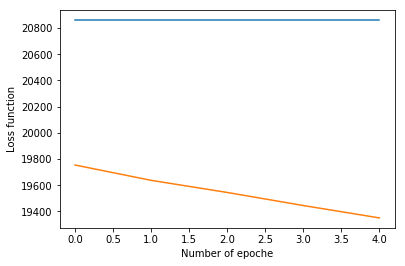

In [27]:
print(loss_graf)
for i,net in enumerate(nets): 
    plt.plot(loss_graf[i])
plt.ylabel('Loss function')
plt.xlabel('Number of epoche')
plt.show()

In [28]:
def test_acc(): # точность классификации
    correct = 0
    for i,net in enumerate(nets):
        net.eval()
        for x,y in test_loader:
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()     
            out[i] = net(x)    
            correct += out[i].argmax(1).eq(y).sum().cpu().numpy()
        print (correct / len(test_data))
test_acc()

0.1022
0.9963


In [36]:
# коэффициенты информативности, см. статью practical variational inference
# попробуем удалять параметры первого слоя по этому коэффициенту
mu = net[0].mean 
sigma = t.exp(2*net[0].log_sigma)
prune_coef = (mu**2/sigma).cpu().detach().numpy() 



In [37]:
# будем удалять по 10% от модели и смотреть качество
sorted_coefs = np.sort(prune_coef.flatten())
for i in range(10):
    ids = (prune_coef <= sorted_coefs[round(i/10*len(sorted_coefs))]) 
    net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
    print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
    (test_acc())
    

nonzero params:  tensor(0.9999, device='cuda:0')
0.8876
nonzero params:  tensor(0.8999, device='cuda:0')
0.8888
nonzero params:  tensor(0.7999, device='cuda:0')
0.8886
nonzero params:  tensor(0.6999, device='cuda:0')
0.8853
nonzero params:  tensor(0.5999, device='cuda:0')
0.8778
nonzero params:  tensor(0.4999, device='cuda:0')
0.8597
nonzero params:  tensor(0.3999, device='cuda:0')
0.8473
nonzero params:  tensor(0.2999, device='cuda:0')
0.8424
nonzero params:  tensor(0.1999, device='cuda:0')
0.8373
nonzero params:  tensor(0.0999, device='cuda:0')
0.5528


In [38]:
# проверяем, что фокусов тут нет, удаляем оставшиеся 10%\
for i in range(10):
    ids = (prune_coef <= sorted_coefs[round((0.9+i/100)*len(sorted_coefs))]) 
    net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
    print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
    (test_acc())
    
net[0].mean.data*=0
print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
(test_acc())

nonzero params:  tensor(0.0999, device='cuda:0')
0.5528
nonzero params:  tensor(0.0899, device='cuda:0')
0.514
nonzero params:  tensor(0.0798, device='cuda:0')
0.4514
nonzero params:  tensor(0.0699, device='cuda:0')
0.4412
nonzero params:  tensor(0.0598, device='cuda:0')
0.3953
nonzero params:  tensor(0.0499, device='cuda:0')
0.3444
nonzero params:  tensor(0.0399, device='cuda:0')
0.3026
nonzero params:  tensor(0.0298, device='cuda:0')
0.2887
nonzero params:  tensor(0.0199, device='cuda:0')
0.2417
nonzero params:  tensor(0.0098, device='cuda:0')
0.2247
nonzero params:  tensor(0., device='cuda:0')
0.101
